## Bernoulli VCM Results 


This notebook goes over the code needed to reproduce the results from the MSE and time figures for the Bernoulli base distribution with Logit Link and covariance matrix $\Gamma$ structured under variance component model framework as follows:

$$
\Gamma = \sigma_1 * \mathbf{1_{n} 1_{n}^\top}
$$

In this example simulate three fixed effects under our Quasi-Copula model with $\beta \sim$ rand(Uniform(-0.2, 0.2), p) where p = 3 fixed effects.

We run each scenario 100 times and compare the fit of ours with that of GLMM's random intercept model from MixedModels.jl. 

In [1]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [2]:
using GLMCopula, DelimitedFiles, LinearAlgebra, Random, GLM
using Random, Roots, SpecialFunctions, DataFrames

In [3]:
p = 3    # number of fixed effects, including intercept
m = 1    # number of variance components
# true parameter values
Random.seed!(1234)
βtrue = rand(Uniform(-0.2, 0.2), p)
θtrue = [0.1]

# generate data
intervals = zeros(p + m, 2) #hold intervals
curcoverage = zeros(p + m) #hold current coverage resutls
trueparams = [βtrue; θtrue] #hold true parameters

#simulation parameters
samplesizes = [100; 1000; 10000]
ns = [2; 5; 10; 15; 20; 25]
nsims = 100;

In [4]:
@info "reading in the files with results"
βMseresult = vec(readdlm("mse_beta_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))
θMseresult = vec(readdlm("mse_Sigma_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))
fittimes_QC = vec(readdlm("fittimes_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))

┌ Info: reading in the files with results
└ @ Main In[4]:1


1800-element Vector{Float64}:
 0.218237624
 0.045270085
 0.080927918
 0.287890016
 0.156615386
 0.059528691
 0.066082229
 0.124962209
 0.078629515
 0.104523598
 0.104770028
 0.069334507
 0.024577379
 ⋮
 7.309460325
 5.756352528
 7.343185085
 5.785768093
 6.755313145
 3.254755581
 6.288860773
 5.670475671
 7.694188736
 5.96978665
 6.240926877
 5.978145102

In [5]:
fittimes_GLMM = vec(readdlm("fittimes_GLMM_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))

1800-element Vector{Float64}:
  0.29030098
  0.032691362
  0.01500607
  0.181438708
  0.012516429
  0.01196003
  0.01584005
  0.027702579
  0.015417419
  0.01243522
  0.020063578
  0.014842378
  0.020588503
  ⋮
 49.655377989
 36.796341949
 36.548480879
 43.24724624
 38.36194286
 33.119383055
 42.016023263
 42.048840325
 34.065484897
 30.635525596
 34.300337574
 40.264127356

In [6]:
#simulation parameters
@info "making results table Quasi-Copula"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_QC)
timedf1 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf1, Dict(:fittimes_function => "se"))
timedf1[!, :nobs] = Meta.parse.(timedf1[!, :samplesize]) .* Meta.parse.(timedf1[!, :obssize])
timedf1[!, :fitmin] = timedf1[!, :fittime] - timedf1[!, :se]
timedf1[!, :fitmax] = timedf1[!, :fittime] + 2 * timedf1[!, :se]
timedf1[!, :perobsratio] = timedf1[!, :fittime] ./ timedf1[!, :nobs]
timedf1

┌ Info: making results table Quasi-Copula
└ @ Main In[6]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,0.0757835,0.00423993,200,0.0715436,0.0842634,0.000378918
2,100,5,0.0859255,0.00226216,500,0.0836633,0.0904498,0.000171851
3,100,10,0.0879848,0.0018932,1000,0.0860916,0.0917712,8.79848e-5
4,100,15,0.100295,0.00191606,1500,0.0983792,0.104127,6.68635e-5
5,100,20,0.109016,0.0052839,2000,0.103732,0.119584,5.45081e-5
6,100,25,0.109509,0.00226345,2500,0.107245,0.114036,4.38035e-5
7,1000,2,0.12608,0.00443086,2000,0.121649,0.134941,6.30398e-5
8,1000,5,0.216009,0.0115137,5000,0.204495,0.239036,4.32018e-5
9,1000,10,0.275668,0.00582621,10000,0.269841,0.28732,2.75668e-5


In [7]:
#simulation parameters
@info "making results table GLMM"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_GLMM)
timedf2 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf2, Dict(:fittimes_function => "se"))
timedf2[!, :nobs] = Meta.parse.(timedf2[!, :samplesize]) .* Meta.parse.(timedf2[!, :obssize])
timedf2[!, :fitmin] = timedf2[!, :fittime] - timedf2[!, :se]
timedf2[!, :fitmax] = timedf2[!, :fittime] + timedf2[!, :se]
timedf2[!, :perobsratio] = timedf2[!, :fittime] ./ timedf2[!, :nobs]
timedf2

┌ Info: making results table GLMM
└ @ Main In[7]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,0.0210774,0.00322888,200,0.0178486,0.0243063,0.000105387
2,100,5,0.0438658,0.00221939,500,0.0416465,0.0460852,8.77317e-5
3,100,10,0.120613,0.00578809,1000,0.114825,0.126401,0.000120613
4,100,15,0.195168,0.00798231,1500,0.187185,0.20315,0.000130112
5,100,20,0.282728,0.0136173,2000,0.269111,0.296346,0.000141364
6,100,25,0.370399,0.0158371,2500,0.354562,0.386236,0.00014816
7,1000,2,0.171767,0.00599493,2000,0.165772,0.177762,8.58837e-5
8,1000,5,0.606951,0.0176216,5000,0.589329,0.624572,0.00012139
9,1000,10,1.5436,0.0505172,10000,1.49308,1.59412,0.00015436


┌ Warning: RCall.jl: Warning: package ‘ggplot2’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160
┌ Warning: RCall.jl: Warning: package ‘cowplot’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160


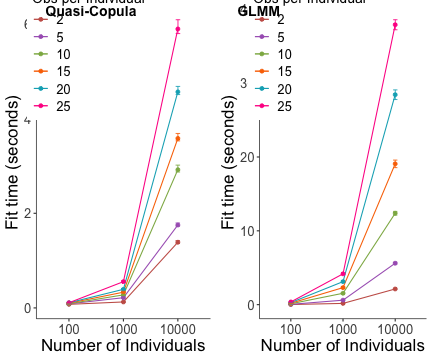

RObject{VecSxp}


In [8]:
########### plot the runtimes
using RCall
@rput timedf1
@rput timedf2
R"""
library(ggplot2)
library(cowplot)
timedf1$obssize = factor(timedf1$obssize, levels = c('2', '5', '10', '15', '20', '25'))
timedf1$samplesize = factor(timedf1$samplesize, levels = c('100', '1000', '10000'))

fittime_1 = ggplot(timedf1, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.3,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

timedf2$obssize = factor(timedf2$obssize, levels = c('2', '5', '10', '15', '20', '25'))
timedf2$samplesize = factor(timedf2$samplesize, levels = c('100', '1000', '10000'))

fittime_2 = ggplot(timedf2, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.3,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

fittime_nsamples = plot_grid(fittime_1, fittime_2, labels = c("Quasi-Copula", "GLMM"))
"""

In [9]:
R"""
ggsave('fittime_nsamples_logistic_vs_glmm.png', fittime_nsamples, width = 15, height = 17, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "fittime_nsamples_logistic_vs_glmm.png"


In [10]:
######  supplementary table s1
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem

βθcoverage = readdlm("beta_sigma_coverage_multivariate_logistic_vcm$(nsims)reps_sim.csv", ',')

m  = 1

covdf = DataFrame(Matrix(transpose(βΣcoverage)), :auto)
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["θ$i" for i in 1:m]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p]; ["θ$i" for i in 1:m]])])
# deletecols!(covdfdisplay, p + 2)
covdfdisplay


,people_obs,β1,β2,β3,Σ1
,String,Tuple…,Tuple…,Tuple…,Tuple…
1,N: 100 ni: 2,"(0.79, 0.040936)","(0.72, 0.0451261)","(0.75, 0.0435194)","(0.89, 0.0314466)"
2,N: 100 ni: 5,"(0.94, 0.0238683)","(0.86, 0.0348735)","(0.77, 0.0422953)","(0.87, 0.0337998)"
3,N: 100 ni: 10,"(0.94, 0.0238683)","(0.83, 0.0377525)","(0.83, 0.0377525)","(0.88, 0.0326599)"
4,N: 100 ni: 15,"(0.91, 0.0287623)","(0.93, 0.0256432)","(0.81, 0.0394277)","(0.88, 0.0326599)"
5,N: 100 ni: 20,"(0.87, 0.0337998)","(0.87, 0.0337998)","(0.88, 0.0326599)","(0.91, 0.0287623)"
6,N: 100 ni: 25,"(0.89, 0.0314466)","(0.85, 0.035887)","(0.81, 0.0394277)","(0.92, 0.027266)"
7,N: 1000 ni: 2,"(0.88, 0.0326599)","(0.88, 0.0326599)","(0.88, 0.0326599)","(0.85, 0.035887)"
8,N: 1000 ni: 5,"(0.98, 0.0140705)","(0.85, 0.035887)","(0.89, 0.0314466)","(0.98, 0.0140705)"
9,N: 1000 ni: 10,"(0.93, 0.0256432)","(0.84, 0.0368453)","(0.84, 0.0368453)","(0.96, 0.0196946)"


In [15]:
#### 
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem

βMseresult = vec(readdlm("mse_beta_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))
θMseresult = vec(readdlm("mse_Sigma_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))

βMseresult_GLMM = vec(readdlm("mse_beta_GLMM_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))
θMseresult_GLMM = vec(readdlm("mse_Sigma_GLMM_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))


p = 3; m = 1
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))
msedf1 = DataFrame(βmse = βMseresult, thetamse = θMseresult, 
    samplesize = sample_sizes, obssize = obs_sizes)

msedf2 = DataFrame(βmse = βMseresult_GLMM, thetamse = θMseresult_GLMM, 
    samplesize = sample_sizes, obssize = obs_sizes)

#rename to make parsing easier for R.

msedf1 = deepcopy(msedf1)
rename!(msedf1, ["betamse"
    "thetamse"
    "samplesize"
 "obssize"]);

msedf2 = deepcopy(msedf2)
rename!(msedf2, ["betamse"
    "thetamse"
    "samplesize"
 "obssize"]);

mses = [msedf1[!, :betamse]; msedf1[!, :thetamse]; msedf2[!, :betamse]; msedf2[!, :thetamse]]
    # msedfnormR[!, :betamse]; msedfnormR[!, :taumse]; msedfnormR[!, :Sigmamse]]
obssize = [collect([repeat(msedf1[!, :obssize], 2)]...) ; collect([repeat(msedf2[!, :obssize], 2)]...)]
#40
samplesize = [collect([repeat(msedf1[!, :samplesize], 2)]...) ; collect([repeat(msedf2[!, :samplesize], 2)]...)]

parameters = [collect([repeat(string.([:beta, :theta]), inner = nsims * length(ns) * length(samplesizes))]...) ; collect([repeat(string.([:beta, :theta]), inner = nsims * length(ns) * length(samplesizes))]...)]
robust = [collect([repeat(["Bernoulli Quasi-Copula"], 2 * nsims * length(ns) * length(samplesizes))]...); collect([repeat(["Bernoulli GLMM"],  2 * nsims * length(ns) * length(samplesizes))]...)]

msedfR = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, robust = robust)

#5 of the 30,000 simulations did not converge, filter out
msedfR = filter(x -> !isnan(x.mse), msedfR)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
msedfR = filter(x -> x.mse < 40000, msedfR)

,mse,obssize,samplesize,parameters,robust
,Float64,String,String,String,String
1,0.0197274,2,100,beta,Bernoulli Quasi-Copula
2,0.0626696,2,100,beta,Bernoulli Quasi-Copula
3,0.00685847,2,100,beta,Bernoulli Quasi-Copula
4,0.0384419,2,100,beta,Bernoulli Quasi-Copula
5,0.0238278,2,100,beta,Bernoulli Quasi-Copula
6,0.0203738,2,100,beta,Bernoulli Quasi-Copula
7,0.00491553,2,100,beta,Bernoulli Quasi-Copula
8,0.00184381,2,100,beta,Bernoulli Quasi-Copula
9,0.0575443,2,100,beta,Bernoulli Quasi-Copula


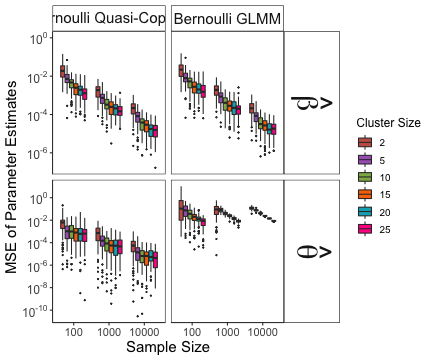

RObject{VecSxp}


In [22]:
### working on figure next
@rput msedfR

R"""
library(scales)
library(ggplot2)
library(data.table)

msedfR = data.table(msedfR)

msedfR[parameters == "beta",y_min := 10^-6]
msedfR[parameters == "beta",y_max := 10^0]
msedfR[parameters == "theta",y_min := 10^-5]
msedfR[parameters == "theta",y_max := 10^1]

#msedfR[parameters == "beta",y_min := 10^-8]
#msedfR[parameters == "beta",y_max := 10^-2]
#msedfR[parameters == "tau",y_min := 10^-8]
#msedfR[parameters == "tau",y_max := 10^-2]
#msedfR[parameters == "Sigma",y_min := 10^-5]
#msedfR[parameters == "Sigma",y_max := 10^-2]


msedfR$obssize = factor(msedfR$obssize, levels = c('2', '5', '10', '15', '20', '25'))
msedfR$samplesize = factor(msedfR$samplesize, levels = c('100', '1000', '10000'))
msedfR$parameters = factor(msedfR$parameters, levels = c('beta', 'theta'), labels = c(beta = expression(hat(bold(beta))), theta = expression(hat(bold(theta))[])))
msedfR$robust <- factor(msedfR$robust, levels = c('Bernoulli Quasi-Copula', 'Bernoulli GLMM'),
    labels = c(expression(paste("Bernoulli Quasi-Copula")), expression(paste("Bernoulli GLMM"))))


#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot = ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=15),
        axis.text.y = element_text(angle=0, size=15), axis.title.x = element_text(size = 20), 
        axis.title.y = element_text(size = 20), legend.title = element_text(size = 20),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=15), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(size=30, face="bold"),
        strip.text.x = element_text(size=20)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-10, 10, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Sample Size", y = "MSE of Parameter Estimates", fill = "Cluster Size") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 
"""

In [23]:
R"""
ggsave('updated_msefacetplot_bernoulli.png', mseplot, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "updated_msefacetplot_bernoulli.png"
